In [2]:
!pip install decord


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 114.5 MB/s eta 0:00:00


In [3]:
import os
import time
import cv2
import torch
import numpy as np
from decord import VideoReader, cpu
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [4]:
# Set device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

CLIP_LENGTH = 32
FRAME_SIZE = 256

In [6]:
# Download Kinetics-400 label map file (only run once per session)
import urllib.request
LABELS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
urllib.request.urlretrieve(LABELS_URL, "kinetics_labels.txt")


('kinetics_labels.txt', <http.client.HTTPMessage at 0x7c42591445f0>)

In [15]:
# Load Kinetics-400 labels
with open("kinetics_labels.txt", "r") as f:
    kinetics_labels = [line.strip() for line in f.readlines()]

print(f"Total Kinetics-400 labels: {len(kinetics_labels)}")
print("Sample labels:", kinetics_labels[:10])  # Show first 10 labels

# Define keywords for "punch" group
punch_keywords = ["punch", "boxing"]

# Group labels into punch and non-punch
punch_labels = []
non_punch_labels = []

for label in kinetics_labels:
    label_lower = label.lower()
    if any(keyword in label_lower for keyword in punch_keywords):
        punch_labels.append(label)
    else:
        non_punch_labels.append(label)

# Display grouping results
print("\n--- Punch-related classes ---")
for pl in punch_labels:
    print(pl)
print(f"\nTotal punch-related classes: {len(punch_labels)}")

print("\n--- Non-punch classes (rest of Kinetics labels) ---")
print(f"Total non-punch classes: {len(non_punch_labels)}")

# Optional: show first 10 non-punch classes
print("\nSample non-punch classes:", non_punch_labels[:10])


Total Kinetics-400 labels: 400
Sample labels: ['abseiling', 'air drumming', 'answering questions', 'applauding', 'applying cream', 'archery', 'arm wrestling', 'arranging flowers', 'assembling computer', 'auctioning']

--- Punch-related classes ---
beatboxing
punching bag
punching person (boxing)
unboxing

Total punch-related classes: 4

--- Non-punch classes (rest of Kinetics labels) ---
Total non-punch classes: 396

Sample non-punch classes: ['abseiling', 'air drumming', 'answering questions', 'applauding', 'applying cream', 'archery', 'arm wrestling', 'arranging flowers', 'assembling computer', 'auctioning']


In [7]:
# Load Kinetics-400 labels
with open("kinetics_labels.txt", "r") as f:
    KINETICS_LABELS = [line.strip().lower() for line in f.readlines()]

def evaluate_model_action_data(data_dir, action_model):
    classes = ['non_punch', 'punch']
    label_to_idx = {cls: idx for idx, cls in enumerate(classes)}

    preds = []
    true_labels = []
    confidences = []
    total_frames = 0
    start_time = time.time()

    for cls in classes:
        cls_dir = os.path.join(data_dir, cls)
        if not os.path.exists(cls_dir):
            print(f"Warning: {cls_dir} not found. Skipping this class.")
            continue
        video_files = [os.path.join(cls_dir, f) for f in sorted(os.listdir(cls_dir)) if f.endswith(('.avi', '.mp4', '.mov', '.mkv'))]
        print(f"Found {len(video_files)} videos in {cls_dir}")

        for video_path in video_files:
            try:
                vr = VideoReader(video_path, ctx=cpu(0))
                frame_buffer = []
                for i in range(len(vr)):
                    frame = vr[i].asnumpy()
                    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                    frame_buffer.append(frame)
                    if len(frame_buffer) == CLIP_LENGTH:
                        resized = [cv2.resize(f, (FRAME_SIZE, FRAME_SIZE)) for f in frame_buffer]
                        frames = np.array(resized).transpose(3, 0, 1, 2) / 255.0
                        frames = torch.tensor(frames, dtype=torch.float32).unsqueeze(0).to(DEVICE)
                        slow_frames = frames[:, :, ::4, :, :]
                        inputs = [slow_frames, frames]
                        with torch.no_grad():
                            preds_logits = action_model(inputs)
                            conf_softmax = preds_logits.softmax(dim=1)
                            conf, pred_class = torch.max(conf_softmax, 1)
                        pred_label_str = KINETICS_LABELS[pred_class.item()]
                        is_punch = 1 if ("punch" in pred_label_str or "boxing" in pred_label_str) else 0
                        preds.append(is_punch)
                        true_labels.append(label_to_idx[cls])
                        confidences.append(conf.item())
                        frame_buffer = []
                total_frames += len(vr)
            except Exception as e:
                print(f"Error processing {video_path}: {str(e)}")
                continue

    total_time = time.time() - start_time
    return {
        "true_labels": np.array(true_labels),
        "preds": np.array(preds),
        "confidences": np.array(confidences),
        "total_frames": total_frames,
        "total_time": total_time,
    }

In [9]:
!pip install pytorchvideo


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 20.8 MB/s eta 0:00:00
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.5-py3-none-any.whl size=188686 sha256=02189456b5fb7ccf1f4df1ba584689c103f97763b38d9db0c1ee6cf237742e58
  Stored in directory: /root/.cache/pip/wheels/b3/49/dc/aab2dce83e38b59849db13a4f4ddd220e568e24b58332fb0f9
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=b5cf128d4574812f331829a75492864e928b72b36e937b54f470c13c4812ccda
  Stored in directory: /root/.cache/pip/wheels/ed/9f/a5/e4f5b27454ccd4596bd8b62432c7d6b1ca9fa22aef9d70a16a
  Created wheel f

In [11]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
from pytorchvideo.models.hub import slowfast_r50
action_model = slowfast_r50(pretrained=True).to(DEVICE).eval()

test_dir = "/content/drive/MyDrive/action_data"   # <--- YOUR DATASET PATH HERE
results = evaluate_model_action_data(test_dir, action_model)


Found 187 videos in /content/drive/MyDrive/action_data/non_punch
Found 140 videos in /content/drive/MyDrive/action_data/punch



Model Evaluation Metrics
----------------------------------------
Accuracy           : 0.5731
Precision          : 1.0000
Recall             : 0.2413
F1 Score           : 0.3888
Average Precision  : 0.5126
Confusion Matrix:
 [[876   0]
 [855 272]]
Classification Report:
               precision    recall  f1-score   support

   non_punch       0.51      1.00      0.67       876
       punch       1.00      0.24      0.39      1127

    accuracy                           0.57      2003
   macro avg       0.75      0.62      0.53      2003
weighted avg       0.78      0.57      0.51      2003



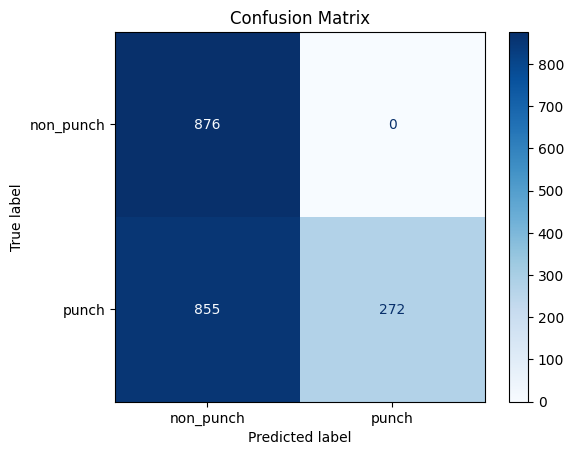

In [13]:
# Compute metrics and plot (identical to previous)
true_labels = results["true_labels"]
preds = results["preds"]
confidences = results["confidences"]

accuracy = (preds == true_labels).mean()
precision = precision_score(true_labels, preds, average="binary")
recall = recall_score(true_labels, preds, average="binary")
f1 = f1_score(true_labels, preds, average="binary")
ap = average_precision_score(true_labels, confidences)
cm = confusion_matrix(true_labels, preds)
report = classification_report(true_labels, preds, target_names=["non_punch", "punch"])

print("\nModel Evaluation Metrics")
print("-"*40)
print(f"Accuracy           : {accuracy:.4f}")
print(f"Precision          : {precision:.4f}")
print(f"Recall             : {recall:.4f}")
print(f"F1 Score           : {f1:.4f}")
print(f"Average Precision  : {ap:.4f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non_punch', 'punch']).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


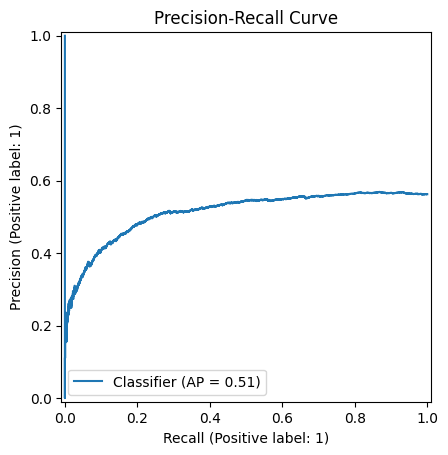

In [14]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(true_labels, confidences)
plt.title("Precision-Recall Curve")
plt.show()

Version - 2

In [17]:
# Install if needed (uncomment to run)
!pip install pytorchvideo torchvision decord

In [19]:
!pip install torch==2.0.1 torchvision==0.15.2 --extra-index-url https://download.pytorch.org/whl/cu118
!pip install git+https://github.com/facebookresearch/pytorchvideo


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
ERROR: Could not find a version that satisfies the requirement torch==2.0.1 (from versions: 2.2.0, 2.2.0+cu118, 2.2.1, 2.2.1+cu118, 2.2.2, 2.2.2+cu118, 2.3.0, 2.3.0+cu118, 2.3.1, 2.3.1+cu118, 2.4.0, 2.4.0+cu118, 2.4.1, 2.4.1+cu118, 2.5.0, 2.5.0+cu118, 2.5.1, 2.5.1+cu118, 2.6.0, 2.6.0+cu118, 2.7.0, 2.7.0+cu118, 2.7.1, 2.7.1+cu118, 2.8.0)
ERROR: No matching distribution found for torch==2.0.1
  Cloning https://github.com/facebookresearch/pytorchvideo to /tmp/pip-req-build-33ibhhae
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorchvideo /tmp/pip-req-build-33ibhhae
  Resolved https://github.com/facebookresearch/pytorchvideo to commit 6cdc929315aab1b5674b6dcf73b16ec99147735f
  Preparing metadata (setup.py) ... done


In [21]:
# Change import in pytorchvideo source from functional_tensor to functional
!sed -i 's/import torchvision.transforms.functional_tensor as F_t/import torchvision.transforms.functional as F_t/' $(python -c "import os,pytorchvideo; print(os.path.dirname(pytorchvideo.__file__))")/transforms/augmentations.py


In [34]:
import os
import time
import torch
import numpy as np
import cv2
from decord import VideoReader, cpu
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import urllib.request

from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import ApplyTransformToKey, UniformTemporalSubsample, ShortSideScale, Normalize
from torchvision.transforms import Compose, Lambda, CenterCrop
from pytorchvideo.models.hub import slowfast_r50

In [35]:
# Device setup
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Download Kinetics-400 labels if needed
# LABELS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
# urllib.request.urlretrieve(LABELS_URL, "kinetics_labels.txt")
with open("kinetics_labels.txt", "r") as f:
    KINETICS_LABELS = [line.strip().lower() for line in f.readlines()]

print(f"Loaded {len(KINETICS_LABELS)} Kinetics-400 labels")

Loaded 400 Kinetics-400 labels


In [29]:
from pytorchvideo.transforms import Normalize, UniformTemporalSubsample, ShortSideScale, ApplyTransformToKey
from torchvision.transforms import Compose, Lambda, CenterCrop


In [36]:
# Define model input transform pipeline (matching SlowFast pretrained)
transform = ApplyTransformToKey(
    key="video",
    transform=Compose([
        UniformTemporalSubsample(32),
        Lambda(lambda x: x / 255.0),
        Normalize(mean=[0.45, 0.45, 0.45], std=[0.225, 0.225, 0.225]),
        ShortSideScale(256),
        CenterCrop(224)
    ]),
)

In [47]:
# SlowFast needs two pathway inputs
def pack_pathway(frames):
    fast_pathway = frames
    slow_pathway = torch.index_select(
        frames, 2, torch.linspace(0, frames.shape[2] - 1, frames.shape[2] // 4).long().to(frames.device)
    )
    return [slow_pathway, fast_pathway]

In [48]:
# Load SlowFast pretrained model
action_model = slowfast_r50(pretrained=True).to(DEVICE)
action_model.eval()

Net(
  (blocks): ModuleList(
    (0): MultiPathWayWithFuse(
      (multipathway_blocks): ModuleList(
        (0): ResNetBasicStem(
          (conv): Conv3d(3, 64, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
          (norm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): ReLU()
          (pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=[0, 1, 1], dilation=1, ceil_mode=False)
        )
        (1): ResNetBasicStem(
          (conv): Conv3d(3, 8, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3), bias=False)
          (norm): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): ReLU()
          (pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=[0, 1, 1], dilation=1, ceil_mode=False)
        )
      )
      (multipathway_fusion): FuseFastToSlow(
        (conv_fast_to_slow): Conv3d(8, 16, kernel_size=(7, 1, 1), st

In [49]:
# Define binary punch vs non-punch keywords
PUNCH_KEYWORDS = ["punch", "beatboxing"
,"punching bag"
,"punching person (boxing)"]

In [50]:
# Helper to predict video clip
def predict_clip(video_path, start_sec, end_sec):
    video = EncodedVideo.from_path(video_path)
    clip = video.get_clip(start_sec=start_sec, end_sec=end_sec)
    clip = transform(clip)
    inputs = pack_pathway(clip["video"].unsqueeze(0).to(DEVICE))  # Add batch dim

    with torch.no_grad():
        preds = action_model(inputs)
        preds = torch.nn.functional.softmax(preds, dim=1)

    conf, pred_class = torch.max(preds, 1)
    label = KINETICS_LABELS[pred_class.item()]
    is_punch = 1 if any(k in label for k in PUNCH_KEYWORDS) else 0
    return is_punch, conf.item(), label

In [51]:
def evaluate_videos_in_folder(folder_path):
    video_preds = []
    video_confs = []

    files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.avi','.mp4','.mov'))]

    for video_path in files:
        try:
            video = EncodedVideo.from_path(video_path)
            duration = video.duration

            clips_preds = []
            clips_confs = []

            clip_duration = 3  # seconds per clip
            start_sec = 0

            while start_sec + clip_duration <= duration:
                pred, conf, _ = predict_clip(video_path, start_sec, start_sec + clip_duration)
                clips_preds.append(pred)
                clips_confs.append(conf)
                start_sec += clip_duration

            final_pred = int(np.round(np.mean(clips_preds)))
            avg_conf = float(np.mean(clips_confs))

            video_preds.append(final_pred)
            video_confs.append(avg_conf)
        except Exception as e:
            print(f"Error processing {video_path}: {e}")
            continue

    return video_preds, video_confs


In [52]:
# Main evaluation loop per class
def evaluate_dataset(data_dir):
    classes = ['non_punch', 'punch']
    label_to_idx = {cls: idx for idx, cls in enumerate(classes)}
    all_true = []
    all_pred = []
    all_conf = []

    for cls in classes:
        folder = os.path.join(data_dir, cls)
        print(f"Evaluating class '{cls}' in folder {folder}")
        video_preds, video_confs = evaluate_videos_in_folder(folder)
        all_true += [label_to_idx[cls]] * len(video_preds)
        all_pred += video_preds
        all_conf += video_confs

    return np.array(all_true), np.array(all_pred), np.array(all_conf)

# Run evaluation
test_dir = "/content/drive/MyDrive/action_data"  # Update your path
true_labels, preds, confidences = evaluate_dataset(test_dir)

Evaluating class 'non_punch' in folder /content/drive/MyDrive/action_data/non_punch
Error processing /content/drive/MyDrive/action_data/non_punch/v_Archery_g05_c04.avi: cannot convert float NaN to integer
Error processing /content/drive/MyDrive/action_data/non_punch/v_Archery_g07_c03.avi: cannot convert float NaN to integer
Error processing /content/drive/MyDrive/action_data/non_punch/v_Archery_g07_c04.avi: cannot convert float NaN to integer
Error processing /content/drive/MyDrive/action_data/non_punch/v_Archery_g07_c06.avi: cannot convert float NaN to integer
Error processing /content/drive/MyDrive/action_data/non_punch/v_Archery_g22_c01.avi: cannot convert float NaN to integer
Error processing /content/drive/MyDrive/action_data/non_punch/v_Archery_g22_c02.avi: cannot convert float NaN to integer
Error processing /content/drive/MyDrive/action_data/non_punch/v_Archery_g22_c04.avi: cannot convert float NaN to integer
Evaluating class 'punch' in folder /content/drive/MyDrive/action_data


Model Evaluation Metrics
----------------------------------------
Accuracy           : 0.9968
Precision          : 1.0000
Recall             : 0.9926
F1 Score           : 0.9963
Average Precision  : 0.4859
Confusion Matrix:
 [[180   0]
 [  1 134]]
Classification Report:
               precision    recall  f1-score   support

   non_punch       0.99      1.00      1.00       180
       punch       1.00      0.99      1.00       135

    accuracy                           1.00       315
   macro avg       1.00      1.00      1.00       315
weighted avg       1.00      1.00      1.00       315



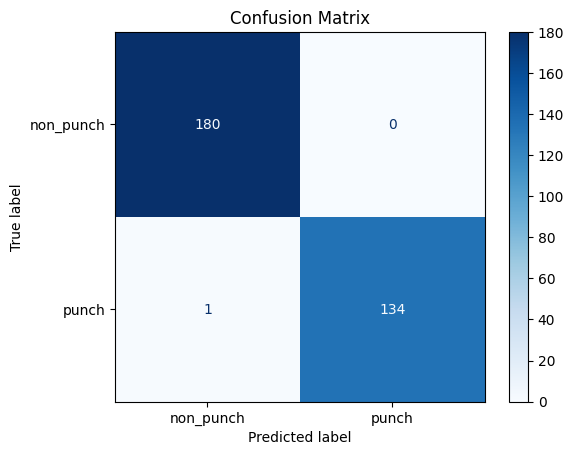

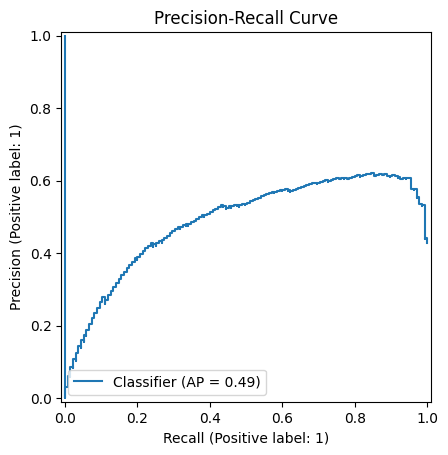

In [53]:
# Calculate metrics
accuracy = (preds == true_labels).mean()
precision = precision_score(true_labels, preds)
recall = recall_score(true_labels, preds)
f1 = f1_score(true_labels, preds)
ap = average_precision_score(true_labels, confidences)
cm = confusion_matrix(true_labels, preds)
report = classification_report(true_labels, preds, target_names=["non_punch", "punch"])

print("\nModel Evaluation Metrics")
print("-" * 40)
print(f"Accuracy           : {accuracy:.4f}")
print(f"Precision          : {precision:.4f}")
print(f"Recall             : {recall:.4f}")
print(f"F1 Score           : {f1:.4f}")
print(f"Average Precision  : {ap:.4f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

# Plot confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["non_punch", "punch"]).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Plot precision-recall curve
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(true_labels, confidences)
plt.title("Precision-Recall Curve")
plt.show()